---
# <span style="color:#2C28B4">Ensemble Models - Bagging & Boosting</span>
---

<img src="azmi.jpg" width=100 height=100 align="right">

Author: Muhammad Azmi Idris

Contact: azmidri@student.ie.edu

Last revision: 25/03/2022

Table of Contents
* [Ensemble Learning](#1)
* [Bagging](#2)
* [Boosting](#3)
* [Similarities and Differences between Bagging and Boosting](#8)
* [Stacking](#4)
* [Discussion on Boosting and Stacking](#5)
* [Practical Excercise](#6)
* [Questions](#7)
 
   


Below code is used for data preparation to demonstrate Bagging and Boosting implementation examples. We will be using Ames Data sets with the help of Pipeline for preprocessing and we are going to build regression model as examples.

###  <span style="color:purple">Required methods - please ignore</span>

In [1]:
from sklearn import set_config

set_config(display="diagram")
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
test_error_df = pd.DataFrame()
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X[features]
    X, y = shuffle(X, y, random_state=0)

    X = X[:600]
    y = y[:600]
    return X, np.log(y)


X, y = load_ames_housing()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)


cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor


cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

test_eval_df = pd.DataFrame(columns = ['Model','Train MSE','Test MSE','Train RMSE','Test RMSE',
                                       'Train MAE','Test MAE','Train $R^2$','Test $R^2$','Elapsed Time'])
test_eval_df = test_eval_df.set_index("Model")
model_eval_df = pd.DataFrame(columns = ['Algorithm','MSE_MAX','MSE_MEAN','MSE_STD','MSE_LIST','R2_MAX','R2_MEAN','R2_STD','R2_LIST'])
model_eval_df = model_eval_df.set_index("Algorithm")

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Parity plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

def test_eval(alg_key,alg_name, X_train, y_train,X_test, y_test, elapsed_time=0):
    """Evaluate mode performance"""
    %matplotlib inline
    import matplotlib.pyplot as plt
    global test_eval_df , errors,test_error_df
    
    y_pred_train = alg_name.predict(X_train)
    train_mse =  round(mean_squared_error(y_train, y_pred_train),2)
    train_rmse =  round(mean_squared_error(y_train, y_pred_train, squared=False),2)
    train_mae =  round(mean_absolute_error(y_train, y_pred_train),2)
    train_r2 =   round(r2_score(y_train, y_pred_train),2)
    y_pred = alg_name.predict(X_test)
    errors = abs(y_pred - y_test)
    test_mse =  round(mean_squared_error(y_test, y_pred),2)
    test_rmse =  round(mean_squared_error(y_test, y_pred, squared=False),2)
    test_mae =  round(mean_absolute_error(y_test, y_pred),2)
    test_errors = abs(y_pred - y_test)
    test_r2 =   round(r2_score(y_test, y_pred),2)
    elapsed_time = round(elapsed_time,2)

    if alg_name in model_eval_df.index:        
        test_eval_df = test_eval_df.drop(alg_name, axis = 0)
        
    test_eval_df.loc[alg_key] =[train_mse,test_mse,train_rmse,test_rmse, train_mae,test_mae, train_r2, test_r2, elapsed_time]
    
    if alg_key in test_error_df.columns:
        test_error_df = test_error_df.drop(alg_key, axis = 1)
    test_error_df[alg_key] = errors
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = np.ravel(axs)
    for count,ax  in enumerate(axs):
        if count == 0:
                plot_regression_results(
                ax, y_train, y_pred_train,
                alg_key + ' Training Set',
                (r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f}$'+ '\n' + r'$MSE={:.2f}$'+ '\n' + r'$MAE={:.2f}$').
                    format(np.mean(train_r2),np.mean(train_rmse),np.mean(train_mse),np.mean(train_mae)), elapsed_time)
        else:
                plot_regression_results(
                ax, y_test, y_pred,
                alg_key + ' Test Set',
                (r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f}$'+ '\n' + r'$MSE={:.2f}$'+ '\n' + r'$MAE={:.2f}$').
                    format(np.mean(test_r2),np.mean(test_rmse),np.mean(test_mse),np.mean(test_mae)), elapsed_time)
    plt.suptitle('Train Vs Test')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    return test_eval_df, test_error_df




## <span style="color:purple">What is Ensemble Learning?<a id="1"></a></span>

In ensemble learning theory, we call weak learners (or base models) models that can be combined to create more complicated models. Most of the time, these basic models do not perform well on their own, either due to significant bias (poor degree of freedom models, for example) or too much variance (high degree of freedom models, for example). For additional information about teh trade os bias and variance , please visit a recommended [website](https://blog.insightdatascience.com/bias-variance-tradeoff-explained-fa2bc28174c4)




The goal of ensemble methods is to combine weak learners to generate a strong learner (or ensemble model) that performs better.

Given their wide use, we can refer to them as “standard” ensemble learning strategies; they are:

* ## <span style="color: purple">Bagging</span>
* ## <span style="color:purple">Boosting</span>
* ## <span style="color:purple">Stacking</span>

---
## <span style="color:purple">Bagging<a id="2"></a></span>
### <span style="color:purple">What is Bagging?</span>

It is an ensemble learning method that seeks a diverse group of ensemble members or models by varying the training data.
Bagging came from the abbreviation of Bootstrap AGGregatING. As the name implies, the two key ingredients of Bagging are bootstrap and aggregation.

<img src="bagging.JPG">
<div align="center"> Bagging image from Aurelio Geron </div>

###  <span style="color:purple">How to do Bagging?</span>
* Use a single machine learning algorithm, almost always an unpruned decision tree
* Decide number of learners then train them on different sample taken from the same training data set
* The method is called bootsrap sampling that involves drawing of sample data repeatedly with replacement.
* Replacement means that if a row is selected, it is returned to the training dataset for potential re-selection in the same training dataset. This means that a row of data may be selected zero, one, or multiple times for a given training dataset.
* Training process is in **parallel**
* Predictions made by the ensemble members are then combined using simple statistics, such as voting (classification)  or averaging (regression).

###  <span style="color:purple">Bagging based - Random Forest</span>
Random forest is an extension of bagging where instead of having same features for all learners, it decorrelates the trees with the introduction of splitting on a random subset of features thus this reduce variation. This means that at each split of the tree, the model considers only a small subset of features rather than all of the features of the model. This is important so that variance can be averaged away.


### <span style="color:purple">Implementation in Python</span>
Bagging is provided via the BaggingRegressor and BaggingClassifier classes under scikit-learn library. For Random Forest,  there are RandomForestClassifier and RandomForestRegressor

---
### <span style="color:purple">Example</span>
Based on UCI ML Breast Cancer Wisconsin (Diagnostic) dataset where the data contains binary target of malignant (0) or benign (1),we build BaggingClassifier

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

data = load_breast_cancer()
X, y = data.data, data.target
seed = 8
kfold = model_selection.KFold(n_splits = 3)
  
# initialize the base classifier
base_cls = DecisionTreeClassifier()
  
# no. of base classifier
num_trees = 500
  
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees,
                          random_state = seed)
  
results = model_selection.cross_val_score(model, X, y, cv = kfold)
print("accuracy :")
print(results.mean())

accuracy :
0.9508029332590736


### <span style="color:purple">Result Overview</span>
Not bad for accuracy of 0.95 :) 

---
## <span style="color:purple">Boosting<a id="3"></a></span>
### <span style="color:purple">What is Boosting?</span>

It is an ensemble modeling technique that attempts to build a strong classifier from the number of weak classifiers. 
Unlike Bagging, it is done by building a model by using weak models in **sequential** and not in **parallel**.

<img src="boosting.JPG">
<div align="center"> Boosting image from Aurelio Geron </div>


###  <span style="color:purple">How to do Boosting?</span>
* Firstly, a model is built from the training data. 
* Then the second model is built which tries to correct the errors present in the first model. 
* This procedure is continued and learners are added until either the complete training data set is predicted correctly or    the maximum number of models are added. 
* In other words, training runs **sequentially** and new learner use residuals from previous learner.
* Learners typicaly based on simple decision tree or also called as stump 

### <span style="color:purple">Implementation in Python</span>
Examples of Python implementations are AdaBoostClassifier, AdaBoostRegressor classes under scikit-learn library. Another algoritham for boosting is GardientBoosting in the form of GradientBoostingClassifier and GradientBoostingRegressor.

---

### <span style="color:purple">Example</span>
This time we will use GradientBoostingClassifier based on the same setup of 500 trees on same set of Breast Cancer data


In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier

data = load_breast_cancer()
X, y = data.data, data.target
seed = 8
# no. of base classifier
num_trees = 500
  
# bagging classifier
model = GradientBoostingClassifier(n_estimators=num_trees, learning_rate=1.0,max_depth=1, random_state=seed)
  
results = model_selection.cross_val_score(model, X, y, cv = kfold)
print("accuracy :")
print(results.mean())

accuracy :
0.9613663789102386


### <span style="color:purple">Result Overview</span>
Slighty better then Bagging Classifier at 0.96

---
## <span style="color:#28B463">Similarities Between Bagging and Boosting<a id="8"></span>

Bagging and Boosting, both being the commonly used methods, have a universal similarity of being classified as ensemble methods. Here we will explain the similarities between them.

* Both are ensemble methods to get N learners from 1 learner.
* Both generate several training data sets by random sampling.
* Both make the final decision by averaging the N learners (or taking the majority of them i.e Majority Voting).
* Both are good at reducing variance and provide higher stability.


___
## <span style="color:orange">Differences Between Bagging and Boosting</span>

| Bagging  | Boosting | 
| :- | :- |
| The simplest way of combining predictions that belong to the same type | A way of combining predictions that belong to the different types |
| Aim to decrease variance, not bias | Aim to decrease bias, not variance |
| Each model receives equal weight | Models are weighted according to their performance |
| Each model is built independently | New models are influenced by the performance of previously built models |
| Different training data subsets are randomly drawn with replacement from the entire training dataset | Every new subset contains the elements that were misclassified by previous models |
| Bagging tries to solve the over-fitting problem | Boosting tries to reduce bias |
| If the classifier is unstable (high variance), then apply bagging | If the classifier is stable and simple (high bias) the apply boosting |

<img src="BaggingvsBoosting.JPG">
<div align="center"> Image from https://www.mlstack.cafe/blog/ensemble-learning-interview-questions </div>

---
## <span style="color:purple">Extra ensamble concept - Stacking<a id="4"></a></span>
### <span style="color:purple">What is Stacking?</span>

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. 

While bagging and boosting used homogenous weak learners for ensemble, Stacking often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions. A meta learner inputs the predictions as the features and the target being the ground truth values in data, it attempts to learn how to best combine the input predictions to make a better output prediction


###  <span style="color:purple">How to do Stacking?</span>
* Split the training data into K-folds just like K-fold cross-validation.
* A base model is fitted on the K-1 parts and predictions are made for Kth part.
* We do for each part of the training data
* Base model is then fitted on the whole train data set to calculate its performance on the test set.
* We repeat the last 3 steps for other base models.
* Predictions from the train set are used as features for the second level model.
* Second level model is used to make a prediction on the test set.

<img src="stacking.JPG">
<div align="center"> Boosting image from GeeksforGeeks.com </div>

### <span style="color:purple">Implementation in Python</span>
StackingClassifier and StackingRegressor from scikit learn

---


---
## <span style="color:purple">Use or not to use ensamble techniques?<a id="5"></a></span>

### <span style="color:green">Why use them?</span>
Performance: An ensemble can make better predictions and achieve better performance than any single contributing model. Robustness: An ensemble reduces the spread or dispersion of the predictions and model performance.

https://machinelearningmastery.com/why-use-ensemble-learning/
    
### <span style="color:orange">When Bagging and Boosting should be avoid?</span>
Ensembles can be more difficult to interpret. Sometimes, even the very best ideas cannot be sold to decision makers. Sometimes, the best ideas are not accepted by the final users. Finally, ensembles cost more to create, train, and deploy.

### <span style="color:orange">When to choose between Bagging and Boosting should be avoid?</span>
If there are models with high variance, then it will benefit from bagging. If the model is biased, it is better to use boosting.

https://blogs.perficient.com/2019/11/07/predictive-model-ensembles-pros-and-cons/

---

## <span style="color:purple">Practical Excercise<a id="6"></a></span>
We use sklearn dataset of Ames house property for predicting house price. We use also pipeline to run some imputation and transformation of the data before fitting to the models.

Build prediction models for regression problem by comparing single classifier and ensemble classifiers consist of bagging boosting and stacking. Evaluate the performance of the regression models on test data by using evaluation metrics like R2 or RMSE and visualize the performance with actual and predicted values. Use function **test_eval** to evaluate the performance. Please check the example for single classifier (DecisionTreeRegressor)

Take note that there is no need  hyperparameter tuning for all of the models. Performance might be varied with different but default setting should enough to demonstrate the application of the alogorithm  as requested.

As a starting point below is the code to fit and evaluate single classifier. 

#### <span style="color:purple">Single Classifier of Decision Tree </span>
Here we use DecisionTreeRegressor

In [4]:
dt_pipeline = make_pipeline(tree_preprocessor,DecisionTreeRegressor())
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

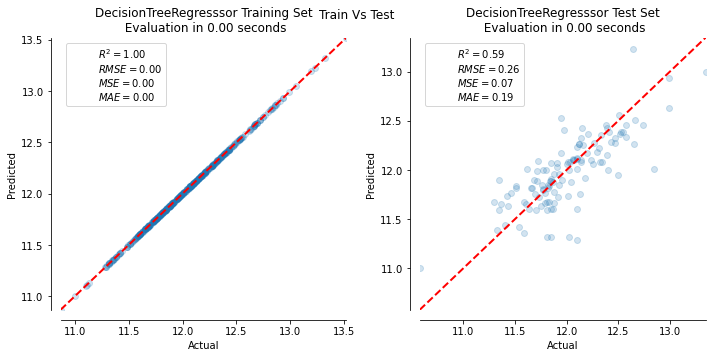

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.0,0.07,0.0,0.26,0.0,0.19,1.0,0.59,0.0


In [5]:
test_eval('DecisionTreeRegresssor',dt_pipeline,X_train,y_train,X_test,y_test)
test_eval_df

Comments: Looks perfect on training but not so good on test. Classic example of overfitting.

---
## <span style="color:purple">Practical Excercise Solutions </span>

####  <span style="color:purple">BaggingRegressor </span>


In [6]:
br_pipeline = make_pipeline(tree_preprocessor,BaggingRegressor(DecisionTreeRegressor(), 
                                                               n_estimators= 500, max_samples = 100, 
                                                               bootstrap=True, n_jobs = -1))
br_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                ('baggingregressor',
                 BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                                  max_samples=100, n_estimators=500,
                                  n_jobs=-1))])

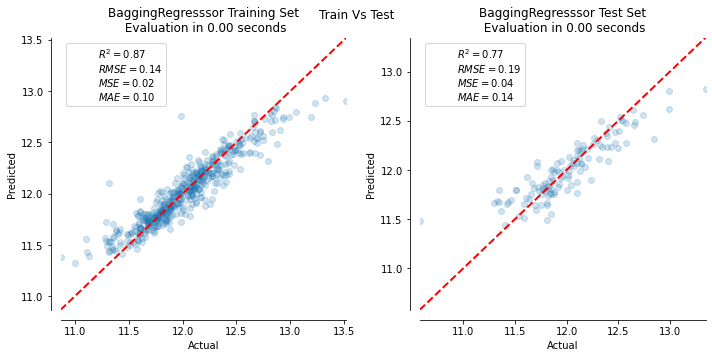

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.00,0.07,0.00,0.26,0.0,0.19,1.00,0.59,0.0
BaggingRegresssor,0.02,0.04,0.14,0.19,0.1,0.14,0.87,0.77,0.0


In [7]:
test_eval('BaggingRegresssor',br_pipeline,X_train,y_train,X_test,y_test)
test_eval_df

Comments: Much better compared to single classifier where overfitting is reduced and better test result

---

####  <span style="color:purple">BaggingRegressor - RandomForest </span>


In [8]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42, 
                                                                     n_estimators= 500, max_samples = 100, ))
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_samples=100, n_estimators=500,
                                       random_state=42))])

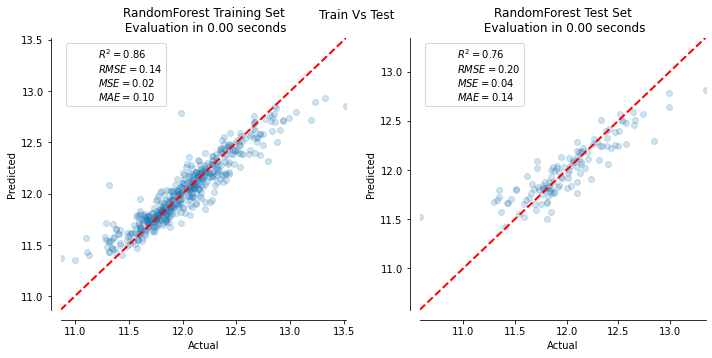

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.00,0.07,0.00,0.26,0.0,0.19,1.00,0.59,0.0
BaggingRegresssor,0.02,0.04,0.14,0.19,0.1,0.14,0.87,0.77,0.0
RandomForest,0.02,0.04,0.14,0.20,0.1,0.14,0.86,0.76,0.0


In [9]:
test_eval('RandomForest',rf_pipeline,X_train,y_train,X_test,y_test)
test_eval_df

Comments: Almost similar performance to BaggingRegressor. Perhaps further tuning on RandomForest might provide better results

---

####  <span style="color:purple">Boosting - AdaBoostRegressor </span>


In [10]:
from sklearn.ensemble import AdaBoostRegressor
ada_pipeline = make_pipeline(tree_preprocessor, AdaBoostRegressor(random_state=42))
ada_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                ('adaboostregressor', AdaBoostRegressor(random_state=42))])

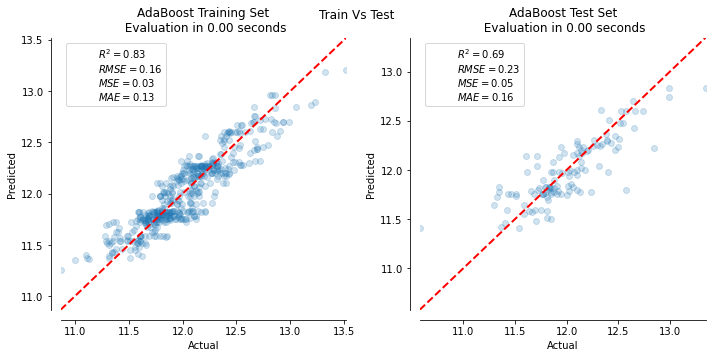

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.00,0.07,0.00,0.26,0.00,0.19,1.00,0.59,0.0
BaggingRegresssor,0.02,0.04,0.14,0.19,0.10,0.14,0.87,0.77,0.0
RandomForest,0.02,0.04,0.14,0.20,0.10,0.14,0.86,0.76,0.0
AdaBoost,0.03,0.05,0.16,0.23,0.13,0.16,0.83,0.69,0.0


In [11]:
test_eval('AdaBoost',ada_pipeline,X_train,y_train,X_test,y_test)
test_eval_df


Comments: Bit lower than Bagging classifiers but still better than single classifier

---

####  <span style="color:purple">Boosting - GradientBoostingRegressor </span>

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
gb_pipeline = make_pipeline(tree_preprocessor, GradientBoostingRegressor(random_state=42))
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

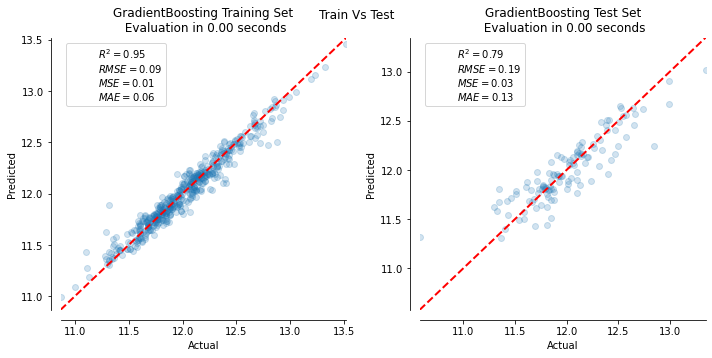

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.00,0.07,0.00,0.26,0.00,0.19,1.00,0.59,0.0
BaggingRegresssor,0.02,0.04,0.14,0.19,0.10,0.14,0.87,0.77,0.0
RandomForest,0.02,0.04,0.14,0.20,0.10,0.14,0.86,0.76,0.0
AdaBoost,0.03,0.05,0.16,0.23,0.13,0.16,0.83,0.69,0.0
GradientBoosting,0.01,0.03,0.09,0.19,0.06,0.13,0.95,0.79,0.0


In [13]:
test_eval('GradientBoosting',gb_pipeline,X_train,y_train,X_test,y_test)
test_eval_df

Comments: GardientBoosting perform the best among the rest

---

####  <span style="color:purple">Stacking </span>
Here we stack all classifiers 

In [14]:

estimators = [
    ("DecisionTreeRegresssor", dt_pipeline),
    ("BaggingRegresssor", br_pipeline),
    ("RandomForest", rf_pipeline),
    ("AdaBoost", ada_pipeline),
    ("GradientBoosting", gb_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('DecisionTreeRegresssor',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <s...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74C40>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB58E74B80>)])),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(random_state=42))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

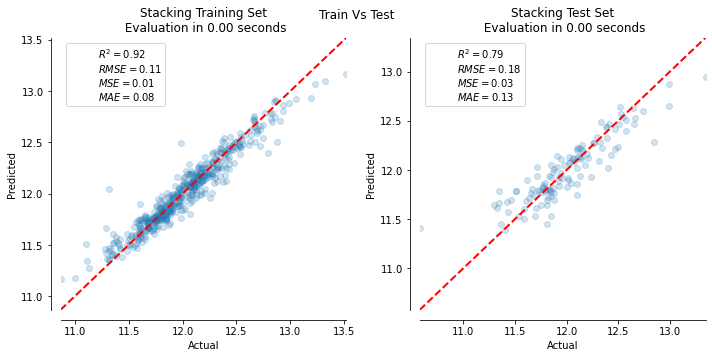

,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train $R^2$,Test $R^2$,Elapsed Time
Model,,,,,,,,,
DecisionTreeRegresssor,0.00,0.07,0.00,0.26,0.00,0.19,1.00,0.59,0.0
BaggingRegresssor,0.02,0.04,0.14,0.19,0.10,0.14,0.87,0.77,0.0
RandomForest,0.02,0.04,0.14,0.20,0.10,0.14,0.86,0.76,0.0
AdaBoost,0.03,0.05,0.16,0.23,0.13,0.16,0.83,0.69,0.0
GradientBoosting,0.01,0.03,0.09,0.19,0.06,0.13,0.95,0.79,0.0
Stacking,0.01,0.03,0.11,0.18,0.08,0.13,0.92,0.79,0.0


In [15]:
test_eval('Stacking',stacking_regressor,X_train,y_train,X_test,y_test)
test_eval_df

Comments: Stacking and GardientBoosting perform the same. One thing very obvious, all of the ensamble alogorithms perform better than single classifier.

---

## <span style="color:purple">Excercise Questions/Answers <a id="7"></a></span>

### What is Ensemble Learning? (Which one is True)

A) Ensemble learning is a machine learning method that uses multiple learning algorithms to obtain a better predictive performance than could be obtained from any of the constituent learning algorithms alone.

B) Ensemble learning is a machine learning method that uses single learning algorithms to obtain a better predictive performance than could be obtained from any of the constituent learning algorithms alone.

C) Ensemble learning is a machine learning method that uses both single and more than one learning algorithms to obtain a better predictive performance than could be obtained from any of the constituent learning algorithms alone.

D)  Ensemble learning is a machine learning method that uses a neural network algorithms to obtain a better predictive performance than could be obtained from any of the constituent learning algorithms alone.

Answer A

### How is a Random Forest related to Decision Trees? (Which one is True)

A) Random forest is an ensemble learning method that works by constructing a multitude of decision trees. 

B) Random forest is an ensemble learning method that works by constructing a multitude of Support Vector Machine. 

C) Random forest is an ensemble learning method that works by constructing a multitude of Liner Regression. 

D) Random forest is an ensemble learning method that works by constructing a multitude of Logistic Regression. 

Answer A

###  Since Ensemble Learning provides better output most of the time, why do you not use it all the time? (Which one is False)
A) Although it provides a better outcome many times, it is true that it will always perform better.

B) There are several ensemble methods, each with its own advantages/disadvantages, and choosing one to use depends on the problem at hand.

C) If there are models with high variance, then it will benefit from bagging. If the model is biased, it is better to use boosting.

D) If the work is in probabilistic setting, the ensemble methods may not work because it is known that boosting delivers poor probability estimates.

Answer A


### What are the differences between Bagging and Boosting?(Which one is False)
A) Bagging mostly aims at increase variance.

B) Boosting is mainly focused on reducing bias. The base models that are considered for boosting are models with a low variance but high bias.

C) Bagging can be parallelized. The different models are fitted independently from each other.

D) Boosting can not be parallelized, and it can become too expensive to fit sequentially several complex models.

Answer A


## <span style="color:purple">Refference </span>

https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/

https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f

https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/

https://www.geeksforgeeks.org/bagging-vs-boosting-in-machine-learning/#:~:text=Similarities%20Between%20Bagging%20and%20Boosting&text=Both%20are%20ensemble%20methods%20to,of%20them%20i.e%20Majority%20Voting).

https://machinelearningmastery.com/bagging-ensemble-with-python/

https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706l

https://www.geeksforgeeks.org/stacking-in-machine-learning/

https://www.mlstack.cafe/blog/ensemble-learning-interview-questions


Aurelio Geron, "Hands on Machine Learning with scikit-learn and Tensorflow." (2017)
